In [18]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Load data and split into train and test

In [19]:
data = pd.read_pickle('df_exp1.pkl')
X = data.drop(columns=["N AufgewAmplitudeNom [MPa]"])
y = data["N AufgewAmplitudeNom [MPa]"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Data preprocessing function: Encode the string features and scale the numerical features

In [20]:
def preprocess(X, X_train, X_test):
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OrdinalEncoder(), categorical_features)
        ]
    )

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, preprocessor

### Function for feature selection with mutual information regression

In [21]:
def select_features_mi(X_train, y_train, X_test, k=15):
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected, selector

### Function for feature selection with Random Forest

In [22]:
def select_features_rf(X_train, y_train, X_test, k):
    model = RandomForestRegressor(random_state=0, n_jobs=4)
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    
    indices = np.argsort(importances)[-k:]
    
    top_features = indices[::-1]
    
    X_train_selected = X_train[:, top_features]
    X_test_selected = X_test[:, top_features]
    
    return X_train_selected, X_test_selected, model

### Function for plotting the feature importances

In [23]:
def plot_feature_importances(features, importances):
    f_i = list(zip(features, importances))
    f_i.sort(key = lambda x : x[1])
    f_i = f_i[-15:]
    plt.barh([x[0] for x in f_i],[x[1] for x in f_i])
    plt.show()

### Get the preprocessed train and test data

In [24]:
X_train_processed, X_test_processed, preprocessor = preprocess(X, X_train, X_test)

### Feature selection result with Random Forest

In [25]:
X_train_selected, X_test_selected, rf = select_features_rf(X_train_processed, y_train, X_test_processed, k=15)

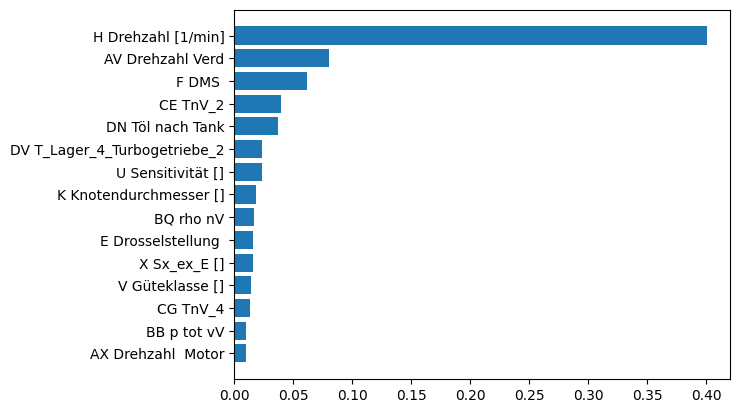

In [26]:
plot_feature_importances(X.columns, rf.feature_importances_)

### Training and evaluating with LinearRegression for comparison

In [27]:
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)
y_pred_lr_model = lr_model.predict(X_test_selected)
mse_lr_model = mean_squared_error(y_test, y_pred_lr_model)
print("Linear Regression MSE:", mse_lr_model)

Linear Regression MSE: 38.520288087760186


### Training and evaluation with DecisionTree and Hyperparameter tuning

In [28]:
dt_model = DecisionTreeRegressor(random_state=0)
dt_model.fit(X_train_selected, y_train)
y_pred_dt_model = dt_model.predict(X_test_selected)
mse_dt_model = mean_squared_error(y_test, y_pred_dt_model)

param_grid_dt_model = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search_dt_model = GridSearchCV(dt_model, param_grid_dt_model, cv=5, scoring='neg_mean_squared_error', n_jobs=4)
grid_search_dt_model.fit(X_train_selected, y_train)

best_dt_model = grid_search_dt_model.best_estimator_
y_pred_dt_model_hyper = best_dt_model.predict(X_test_selected)
mse_dt_model_hyper = mean_squared_error(y_test, y_pred_dt_model_hyper)
print("Decision Tree MSE:", mse_dt_model)
print("Hyperparameter Decision Tree MSE:", mse_dt_model_hyper)
print("Best Decision Tree Params:", grid_search_dt_model.best_params_)

Decision Tree MSE: 2.8572447975314876
Hyperparameter Decision Tree MSE: 2.8013584505492104
Best Decision Tree Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


### Implementation of Neural Networks

#### Initializing the Neural Network

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hl1, hl2, output_size):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(input_size, hl1)
        self.linear2 = nn.Linear(hl1, hl2)
        self.linear3 = nn.Linear(hl2, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        return x

#### Define the parameters for the model

In [30]:
model = NeuralNetwork(15, 32, 16, 1)

loss_module = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#### Create a data loader for batch training

In [31]:
X_train_tensor = torch.tensor(X_train_selected, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_selected, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#### Function for training the model

In [32]:
def train_model(model, optimizer, loss_module, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_module(outputs, targets)
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

#### Function for evaluating the model

In [33]:
def evaluate_model(model, test_loader, loss_module):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = loss_module(outputs, targets)
            total_loss += loss.item()
    
    average_loss = total_loss / len(test_loader)
    return average_loss


#### Training and Evaluating

In [ ]:
train_model(model, optimizer, loss_module, train_loader, epochs=1000)

In [50]:
evaluate_model(model, test_loader, loss_module)

10.122389170049711

#### Exhaustive hyperparameter tuning for neural networks

In [167]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
hl1 = [4, 8, 16, 32]
hl2 = [4, 8, 16, 32]
hyperparameter_combinations = list(product(learning_rates, hl1, hl2))

In [ ]:
best_loss = float('inf')
best_params = None
best_model = None

for lr, hl1, hl2 in hyperparameter_combinations:
    model = NeuralNetwork(input_size=15, hl1=hl1, hl2=hl2, output_size=1)
    
    print(f"Training with lr={lr}, hl1={hl1}, hl2={hl2}")
    train_model(model, optimizer, loss_module, train_loader, epochs=1000)
    test_loss = evaluate_model(model, test_loader, loss_module)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_params = (lr, hl1, hl2)
        best_model = model

print(f"Best Loss: {best_loss}")
print(f"Best Params: Learning Rate={best_params[0]}, Hidden Layer 1={best_params[1]} Hidden Layer 2={best_params[2]}")


### Results

|       `Model`          |`MSE with RandomForest feature selection`|`MSE with MutualInformation feature selection`|
|------------------------|-----------------------------------------|----------------------------------------------|
|`LinearRegression`      |38.520288087760186                       |38.98373613737032															|
|`DecisionTreeRegressor` |2.8013584505492104                       |4.945860836259849															|
|`NeuralNetwork`         |10.744668976951191                       |11.71522496856806															|

- Encoding (OrdinalEncoder) and Scaling (StandartScaler) are done on input training and test data after the split to avoid data leakage.
- Feature selection performed using training data to keep the test dataset unseen to have more accurate results.
- Two methods are implemented for feature selection: Mutual Information Regression and Random Forest.
- The difference between the results for both feature selection methods was not very significant
- Using more than 15 features do not lead to significance change in the result
- LinearRegression unsurprisingly performed poorly compared to other 2 models.
- DecisionTreeRegressor had the best MSE results among the models.
- Hyperparameter tuning for DecisionTreeRegressor did not show significantly better result. Hyperparameter Tuning is done using GridSearch with 5 fold cross validation. However every time the parameters may vary slightly.
- Best Parameters for DTR:  
	-	`max_depth`: 20,  
	- `min_samples_leaf`: 1,  
	- `min_samples_split`: 2
- Neural Network highly dependent on the different parameters, with the optimal parameters it performs well.
- NN model is not stable, repeatedly training the data with the same parameters might lead to slightly different results.
- Due to the computational limits it is not possible to tune the whole range of possible parameters, but with the existing resources the most optimal parameters were selected.
- The hyperparameter tuning is done using exhaustive trials with different combination of parameters.
- The most optimal parameters:
	- `2` hidden layers with `32` and `16` neurons (further increasing the layers, do not improve the result much).
	- `Adam` optimizer is used.
	- MSELoss used for evaluating the model performance.
	- Learning rate for the optimizer `0.01`.
	- The evaluation result depends on the number of epochs used for training. 500-2000 epochs give better result however every time result slightly differs.
